# Grover's Algorithm comparison to classical methods
Ethan Buttery

k22015544

k22015544@kcl.ac.uk

In [146]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister      #needed imports
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit.result import marginal_distribution
from qiskit.circuit.library import UGate
from qiskit_aer.primitives import SamplerV2 as Sampler
from qiskit.quantum_info import Statevector
from qiskit.quantum_info.operators import Operator
import numpy as np

# Abstract
Grover's algorithm was invented in 1996 by Lov Grover was a turning point for quantum algorithms [1]. It demonstrated and proved a quadratic speed up for unstructured search problems. This showed the possible superiority of a quantum computer to a classical one. In this project a Grover algorithm is implemented as well as a classical one for comparison. In the quantum algorithm an Oracle is used to mark states with a phase flip and a diffuser is used to flip amplitudes about the mean. Whereas the classical uses a completely disordered list with randomly assigned solutions to simulate an actual search via a brute-force method. All results produced closely match theoretical predictions, indicating both algorithms were a success. This project shows the use of a Grover algorithm for given data sizes and amount of solutions.

# 1. Grovers algorithm and the disordered search problem

## 1.1 The Unstructured search
In this project the quantum algorithm called the the Grovers search algorithm is used to improve the unstructured search problem. 

The algorithm is given:

- A set of N = $2^{n}$ items. Where n is the length of the bit strings provided.  
- A uniform superposition of all possible states with no structure or ordering.

Real life examples:
- Searching a phone book for a particular name. The name has no orientation on its position in the book. Unlike something like a dictionary.
- Finding an input that satisfies a black box function \(a function where the inputs and outputs are known but the internal function is unknown\).


## 1.2 Classical methods
In the classical method only **brute-force** strategies are used \(methods where you just check each state to see if it's the solution\):
- Select a state x
- Query the oracle function:
   - f : |x> to $(-1)^{n}$|x>
      such that:
      - f(x) = 1 if x is a **marked** or solution state.
      - f(x) = 0 otherwise is non-solution state. 
- If f(x)=0 then check another state.
- If f(x)=1 then the search is finished.

- **Longest scenario**: The marked state or solution is the last item that is checked and therefore N iterations are performed.
- **Expectation scenario**: On average it is expected to be found after $\frac{N}{2}$ iterations.

Hence, in a classical search the time taken to find a solution is linearily related to the number of possible states N.


## 1.3 Grovers quantum improvement 
Grovers algorithm solves the search problem scaling to $N^{0.5}$ [1] iterations using a quantum computer. 

Unlike classical methods, it does not check one item at a time:
1. It starts by attatching each item to one of the N states.
2. Then by applying the Hadamard operator to a |$0^{n}$> state, it forms a uniform superposition, representing every item with equal probability of being found.
3. Then using the same two operations in each iteration:
- The **Oracle**, which marks the solution states by applying a **phase flip** to them.  
- The **Diffuser**, which **flips amplitudes about the mean**, increasing the probability amplitude of the marked states and decreasing the probability amplitude of the unmarked states. Amplitudes that are above the mean are reduced and those below are increased.
- Although the  Hilbert space spans $2^{N}$ dimesnions, the grover algorithm evolves through a 2D subspace spanned by the superposition of solution and non-soliution states, |A1> and |A2>.
- Each iteration applied by the Grover rotates the state vector through this 2D subspace. 
- The closer the state vector aligns with the |A1> state axis, the larger the probability amplitude of the solution states.
- This means too many iterations can overotate the state vector and reduce the probability amplitude of solution states.
- Hence there is an optimal amount of iterations t, to maximize this probabilty amplitude. 


## 1.4 When Grovers algorithm is useful
Useful when:
- The number of items or states is large, meaning a large N.
- There items are unstructured and dissorded.
- There is no classical algorithm better than the brute-force method.

Not useful or negligable when: 
- There is additional structure or patterns, in which classical methods may be more efficient.
- There is a small number of items. The speedup in comparison to classical methods is negligiable.
- Noise in quantum hardware is strong, leaving errors in phase and probability amplitudes.

---

# 2. A comparison between classical and qauntum methods

## 2.1 Classical simulations
To compare the classical methods to the quantum a simple unstructure classical search will be implemented. 

In the following code cells:
- a simulation of a classical search will be perforemd to estimate the number of iterations or Oracle calls for a randomly ordered list with randomly marked states.
- compare this to the number of theoretical iterations of the Grover algorithm 
- demonstrate how they scale with varying input size

In [147]:
import random                                                                                   #Needed imports 
import math
from statistics import mean
import matplotlib.pyplot as plt


def classical_marked_states(classical_n: int, classical_M: int) -> set[int]:                    #Define function for integer value of number of qubits n and integer solutions M.
    classical_N = 2 ** classical_n                                                              #Define the number of possible states
    if classical_M > classical_N:                                                               #number of marked states must be less than the number of states
        raise ValueError("M cannot be larger than 2^n")
    return set(random.sample(range(classical_N), classical_M))                                  #return the value of the random generated order of N and marked states M. Randomly picking M marked states in 0 to N-1 range.
                       

def classical_search_steps(classical_N: int, marked: set[int]) -> int:                          #Define for N integer numbers with a set of marked integers counting how many checks were performed. 

    steps = 0                                                                                   #Starting with 0 checks
    indices = list(range(classical_N))                                                          #Define indices as the range of N numbers
    random.shuffle(indices)                                                                     #Randomly shuffle the list to maintain randomness
    
    for x in indices:                                                                           #Search the range of N in random order
        steps += 1                                                                              #Add 1 to the amount of steps over each check 
        if x in marked:                                                                         #If it is a marked number finish counting steps 
            return steps
    return steps


def estimate_classical_steps(classical_N: int, marked: set[int], trials: int = 1000) -> float:  #Takes N integers, with a set of marked integers M, trials 1000 times to find the number of steps to obtain a solution. 
    total = 0                                                                                   #Total trials completed starts at 0
    for _ in range(trials):                                                                     #Perform over the range of value of trials
        total += classical_search_steps(classical_N, marked)                                    #Add the number of steps calculated from classical_search_steps back to the total
    return total / trials                                                                       #Return the steps per trial

In [148]:
M_values = [1, 2, 4, 8, 16]                                                                  #5 selected fixed amount of solutions for each set

n_values = range(3, 13)                                                                      #number of qubits in range 3-13

trials_per_point = 1000                                                                      #take 1000 trials for each 2^n and M value

results = {M: {'N': [], 'avg_steps': []} for M in M_values}                                  #creates a list associating the fixed M values to the range of N values and their average steps

for classical_M in M_values:                                                                 #checks that the values of M and N are solutions to the inequality before graphing them
    for classical_n in n_values:
        classical_N = 2 ** classical_n
        if classical_M > classical_N:
            continue                                                                         #If they do fulfil the inequality proceed
        
        marked = classical_marked_states(classical_n, classical_M)                           #Now use the function defined earlier to randomize the order of stirng length N and the selected marked states
        avg_steps = estimate_classical_steps(classical_N, marked, trials=trials_per_point)   #Now use thre function define earlier to simuate 1000 searches for this value of N and M and take an average of the steps to find a solution.

        results[classical_M]['N'].append(classical_N)                                        #For fixed number of M appnd the list with values N
        results[classical_M]['avg_steps'].append(avg_steps)                                  #For fixed number of M append a list of average steps to find a solution, associated with a value of N.

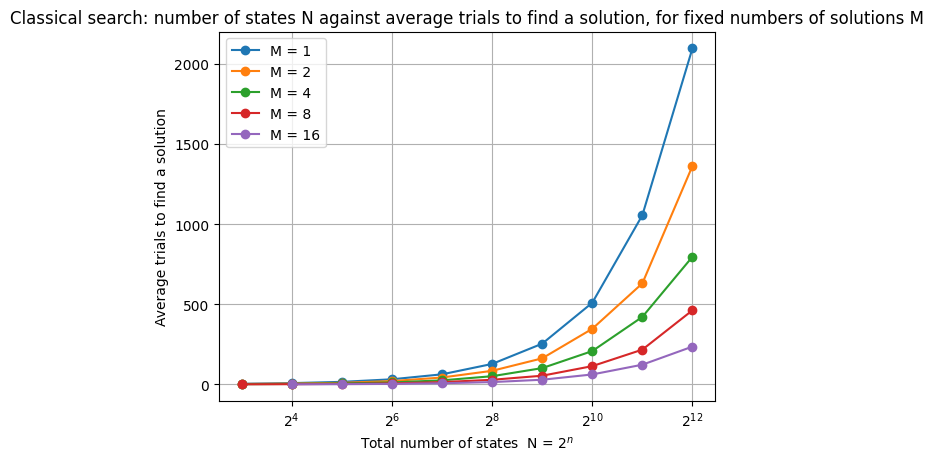

In [149]:
plt.figure()

for classical_M in M_values:                                                #For the M values that fit the inequality earlier
    Ns = results[classical_M]['N']                                          #Retrieves fixed M and their associated N values for graphing
    avg_steps = results[classical_M]['avg_steps']                           #Retrieves fixed M and their associated average step values for graphing
    plt.plot(Ns, avg_steps, marker='o', label=f"M = {classical_M}")         #plot N on the x axis and average steps on the y axis. 

plt.xscale('log', base=2)                                                   #plot it to the power of 2 to highlight the associated n values.
plt.xlabel("Total number of states  N = $2^{n}$")
plt.ylabel("Average trials to find a solution")
plt.title("Classical search: number of states N against average trials to find a solution, for fixed numbers of solutions M")
plt.grid(True)
plt.legend()
plt.show()

It is important to consider that the classical data is subject to error as they are calculated values. The classical data was initially done with 200 trials per point, however this displayed large inaccuracies in comparison to theoretical predictions. Altering the the number of trials per point to 1000 displayed data more closely aligned with what was expected. The expected trials for $2^{12}$ states is calculated from:
$$
steps=\frac{2^{n}+1}{M+1}
$$
When subbing in 12 for n this equation gives 2048. Closely matching the graph. This equation models very well with every point on the graph indicating the classical model to be accurate and successful.



## 2.2 Theoretical Grover 
To compare with these calculated results, the theoretical grover iterations for the same amount of marked solutions and number of states will also be graphed in the code cells below. The grover algorithm will use:
$$
t = \frac{\pi}{4 \, \arcsin\!\left(\sqrt{M/N}\right)} - \frac{1}{2}
$$

to depict the number of iterations. Where M is the number if solutions and N is the total states. Note here the number of iterations is an integer and therefore t is rounded to the nearest number. 

In [150]:
def theoretical_grover_iterations(classical_N: int, classical_M: int) -> int:     #Define the iteration for integer number of N and M
    theta = math.asin(math.sqrt(classical_M / classical_N))                       #Equate theta
    t = int(round(math.pi / (4 * theta) - 0.5))                                   #Define the number of iterations for values of N and M
    return max(1, t)

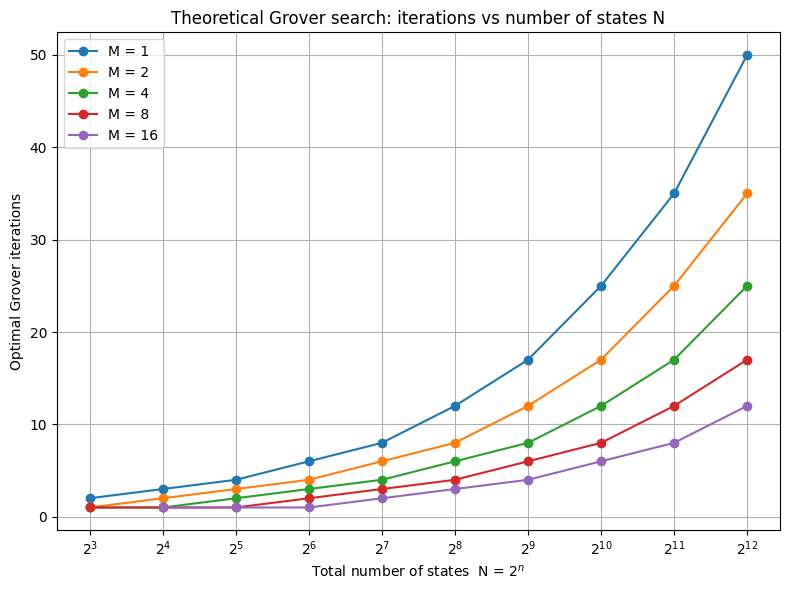

In [151]:
x_positions = np.arange(len(n_values))                                             #evenly spacex positions adjusted for values of n

plt.figure(figsize=(8,6))

for classical_M in M_values:                                                       #For each fixed value of M store amount of iterations for each n
    grover_iters_for_M = []

    for classical_n in n_values:
        classical_N = 2 ** classical_n                                             
        if classical_M > classical_N:                                              #Check values of M are less than N meaning they are valid 
            
            grover_iters_for_M.append(np.nan)                                      #If M is greater than N leave this point blank
        else:
            t = theoretical_grover_iterations(classical_N, classical_M)            #If not append it to the the count of iterations for the graph.
            grover_iters_for_M.append(t)

    plt.plot(
        x_positions,
        grover_iters_for_M,
        marker='o',
        linestyle='-',
        label=f"M = {classical_M}"
    )


plt.xticks(
    x_positions,
    ["$2^{%d}$" % classical_n for classical_n in n_values]                         #Put the x axis in form 2^n
)

plt.xlabel("Total number of states  N = $2^{n}$")
plt.ylabel("Optimal Grover iterations")
plt.title("Theoretical Grover search: iterations vs number of states N")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()




## 2.3 Comparing quantum and classical results
As the graphs display, the disparity in total steps taken at large mount of total states N is massive. As the number of qubits n increases, the gap in steps or iterstions grow larger. For n=9 on the classical graph there is about 250 steps used to find a solution verses 17 iterations on the Grover graph, where as when n= 12 the classical graph has about 2100 steps used compared to 50. This growing gap with the increasing amount of data highlighs the advantages of the the grover algorithm. However, as the amount of solutions M increase, the Grover algorithm is less advantageous, meaning it is most useful for a small amount of solutions with massive amounts of data. This is due to how the search algorithms scale [2]: 

$$
t_{\text{classical}} = O\!\left( \frac{N}{M} \right)
$$

$$
t_{\text{Grover}} = O\!\left( \sqrt{\frac{N}{M}} \right)
$$

These scalings show the quadratic speed up of the Grover's algorithm and why it becomes increasingly useful at large N but negligable for small amounts of data. 

However, this assumes perfect conditions when in relaity there are practical limitations. When implementing many Grover iterations, which is also when they are most useful, it is challenging on noisy quantum hardware. Classical computers do not have this issue and can still execute oracles very quickly.

---

# 3. Designing a Grover algorithm
The Grover algorithm below is designed to increase the probability amplitude of marked state(s) to maximum with the optimal amount of iterations. The algorithm will work for:
- Any number of states.
- Any number of solutions, as long as its less than the number of states.



## 3.1 Selecting states
In the cell below 2 random states have been selected (they must contain the same number of qubits for the algorithm to work) at random. Note the amount of states and their number of qubits n can be altered. It also prints the number of qubits, the number of solutions and the optimal number of Grover iterations for these values.

In [152]:
marked_states = ["010", "110"]            #select desired marked states             
n = len(marked_states[0])                 #Define length of indivdual strings   
M = len(marked_states)                    #Define the amount of states that have been marked or that solutions
N = 2**n                                  #number of possible states for n qubits
theta = np.arcsin(np.sqrt(M/N))           #theta= sin^-1((number of solutions/n)^0.5
t = int(np.round(np.pi/(4*theta)-1/2))    #t=(Pi/4theta - 0.5) to the nearest integer. t is the optimal number of iterations 

print("Number of qubits n =", n)
print("Number of solutions M =", M)
print("Grover iterations t =", t)


Number of qubits n = 3
Number of solutions M = 2
Grover iterations t = 1


## 3.2 The Oracle function

The role of the Oracle in Grover's algorithm is to mark the solution states. Mathematically represented by [3]:

$$
Z_f : |x\rangle \;\longmapsto\; (-1)^{f(x)} |x\rangle 
$$

Where f(x)=1 is a solution and f(x)=0 is not a solution. Hence, when the state is a solution, the Oracle causes a phase flip, whilst leaving non-solutions unchanged. The function 'Oracle_markstate' implements this phase flip to a single marked state.

The circuit works in the following main steps:

1. **Map the marked state to 1.**  
   For each solution state where the qubit value is 0, an x gate is used.
   This temporarily transfroms the solutions states into |$1^{n}$> for the next stage.
  

2. **Apply a multi-controlled Z gate.**  
   Taking advantage of HXH=Z for a single qubit, the multi-controlled Z gate can be formed.
   This function is applied to the solution state that is in the form |$1^{n}$>.
   This operation multiplies the amplitude by -1.
   It also leaves other states unchanged.
   

3. **Map the marked state back.**  
   Applying the same x gate function to the solution states they are mapped back to their orignal form.
   Now the solution states have been marked, as they have been phase flipped.

In [153]:
def Oracle_markstate(marked_state: str):                          #For a single state  

   
    qc = QuantumCircuit(n, name="Oracle")                         #Defines circuit for n qubits and names it Oracle

    for qubit, bit in enumerate(marked_state):                    #For each qubit of the marked state 
        if bit == '0':                                            #If the qubit is 0 outside quantum circuit (original marked state)
            qc.x(qubit)                                           #Apply x-gate, swapping qubits of the 0 postion in the orignal state
                                                                  #Makes marked state |1^n> within quantum circuit

                                                                  #Using HXH=Z, making a multicontrol Z gate
    qc.h(n-1)                                                     #Apply Hadamard to last state (|1^n>)
    qc.mcx(list(range(n-1)), n-1)                                 #Apply multicontrol X gate (0 to n-2 acts as the control and n-1 is the target)
    qc.h(n-1)                                                     #Apply Hadamard to last state (|1^n>)
                                                                  #Overall flips phase of |1^n>


    for qubit, bit in enumerate(marked_state):                    #For each qubit of the marked state
        if bit == '0':                                            #If the qubit is 0 outside quantum circuit (original marked state)
            qc.x(qubit)                                           #Apply x-gate, swapping qubits of the 0 postion of the orignal state
                                                                  #Marked state is now the orignal marked state with a phase flip 
    return qc

This Oracle for a single state is then implemented into function 'Oracles_multiplemark', where the function goes through each value in the list of all possible states, applying the original oracle when a solution state is found. 

In [154]:
def Oracle_multiplemark(marked_states):                           #Oracle for marking multiple states
    
    qc = QuantumCircuit(n, name="Oracle_multiplemark")            #Defining quantum circuit for n qubits and naming it Oracle_multiplemark

    for s in marked_states:                                       #For s is equal to a value in the list each loop  
        single = Oracle_markstate(s)                              #For each value apply the oracle for a single marked state
        qc.compose(single, inplace=True)                          #adds the now phase flipped states to the full circuit

    return qc

## 3.2 The Diffuser
The second part of Grover's algoirthm is the diffuser. The diffuser amplifies the probability amplitude of these marked states. This is because it flips amplitudes about the mean amplitude of all states. Previously, the Oracle has caused all solution states to be negative and therefore below the mean. Now when the flip occurs they will be pushed above the mean and their magnitude would have increased. 
Mathematically the diffuser can be written as [3]: 
$$
D=2|u><u|- I
$$

Where |u> is an uniform superposition of all possible states and I is the idnetity matrice.

In [155]:
def diffuser(n):                                                 #Define Diffuser
    qc = QuantumCircuit(n, name="Diffuser")                      #Define quantum circuit for n qubits and naming it Diffuser
    qc.h(range(n))                                               #apply the Hadamard to each qubit to form a Hadamard basis
    
    qc.x(range(n))                                               #Apply x-gate on all qubits causing an bitwise flip and therefore |0^n> --> |1^n>

                                                                 #Using HXH=Z, making a multicontrol Z gate
    qc.h(n-1)                                                    #Apply Hadamard to last state (|1^n>)
    qc.mcx(list(range(n-1)), n-1)                                #Apply multicontrol X gate (0 to n-2 acts as the control and n-1 is the target)
    qc.h(n-1)                                                    #Apply Hadamard to last state (|1^n>)
                                                                 #Overall flips phase of |1^n>
    
    qc.x(range(n))                                               #Undo x-gate applied before but keeping the applied phase flip 


    qc.h(range(n))                                               #apply Hadamard to each qubit to return it to the computational basis

    return qc                                                    #Overall causes an inversion about the mean of the probability amplitudes 

## 3.3 The Grover

The function 'Grover_iteration" below is used for a single iteration of the algorithm. It applies the Oracle and diffuser function once per iteration. Adding an oracle and diffuser gate each to the quantum circuit. Hence mathematically, a grover iteration can be represented by: 

$$
G=DZ_f=(2|u><u|- I)Z_f
$$

Where D is the diffsuer function and $Z_f$ is the oracle function.

In [156]:
def Grover_iteration(marked_states):                             #Define a single gorver iteration
                                                                 
    qc = QuantumCircuit(n, name="Grover_iteration")              #Define quantume circuit for n qubits and name it Grover_iteration
    
    oracle = Oracle_multiplemark(marked_states)                  #Label the functions
    diff = diffuser(n)  

    qc.compose(oracle, inplace=True)                             #Add oracle gate to the Grover iteration circuit
    qc.compose(diff, inplace=True)                               #Add diffuser gate to the Grover iteration circuit

    return qc 

Now the final function 'Grover" can  be formed. Applying it an optimal t times to for the given marked states, onto a equal superpostion of all possible states. It rotates the state vector as close as possible to the solution states subspace. Logically this can be represented by a grover iteration to the power of t:

$$
G^{t}=(DZ_f)^{t}=((2|u><u|- I)Z_f)^{t}
$$

In [157]:
def Grover(marked_states):                                       #Define grover as t applications of Grover iterations to an equal superposition
    qc = QuantumCircuit(n, name="Grover")
    qc.h(range(n))                                               #Create equal superposition by applying the hadamard to |0^n> state
    
    iteration = Grover_iteration(marked_states)                  #Define a single iterationas the Grover iteration function

    for _ in range(t):                                           #Apply t times
        qc.compose(iteration, inplace=True)                      #Attatch grover iteration to the circuit

    return qc

In [158]:
grover_circuit = Grover(marked_states)                          #Print the amplitudes and their assocaited states
state = Statevector.from_instruction(grover_circuit)            
print("All amplitudes:")
for i, amp in enumerate(state.data):
    bitstring = format(i, f"0{len(marked_states[0])}b")
    print(f"{bitstring}: {amp}")


All amplitudes:
000: 0j
001: 0j
010: (-0.7071067811865467+0j)
011: (-0.7071067811865467+0j)
100: 0j
101: 0j
110: 0j
111: 0j


## 3.4 A unique case
Above is a unique case where the amplitudes of non-marked states have gone to 0. This is due to the value of theta. [4]

$$
\theta=arcsin((\frac{M}{N})^{0.5})
$$

Here M has a value of 2 and N has a value of 8, meaning $\theta$ is equal to the inverse sin function of 0.5, giving $\theta$ a value of $\frac{\pi}{6}$. When this is used in equation:

$$
t=\frac{\pi}{4\theta} - \frac{1}{2}
$$

t does not need to be rounded and is already an integer. This means the statevector has rotated and completely aligned with the solution subspace, leaving no component in the non-solution subpsace, hence their probability amplitudes are zero. This is also a good indicator that the algorithm is correct, as it follows theoretical predictions.

---

# 4. Conclusion

This project successfully implemented a Grover algorithm for any size data set and any amount of solutions, displaying the increased proabability of the marked states. The accuracy of the algorithm was displayed by its alignement with theoretical predictions. 

It also compared a calculated classical search to a theoreical Grover search by plotting their graphs. Once again, this classical algorithm when implementing many trials and taking an average followed theoretical understanding. 

The project also highlighted the usefulness of the Grover's algorithm  and its negligible use in comparison to with classical methods when certain constraints are applied.

Throughout both quantum and classical algorithms an analysis of the code used was performed to demonstrate the clear processes of the algorithms.

---

## References

[1] A fast quantum mechanical algorithm for database search (1996) — by Lov Grover https://arxiv.org/pdf/quant-ph/9605043


[2] Quantum Amplitude Amplification and Estimation (2000) — by Gilles Brassard, Peter Høyer, Michele Mosca and Alain Tapp https://arxiv.org/pdf/quant-ph/0005055 


[3] Quantum Computation and Quantum Information (10-year anniversary / standard edition) — by Michael Nielsen and Isaac Chuang https://almuhammadi.com/sultan/books_2020/Nielsen_Chuang.pdf


[4] Tight bounds on quantum searching (1996) - by Michel Boyer, Gilles Brassard, Peter Høyer and Alain Tapp https://arxiv.org/pdf/quant-ph/9605034